## Frequency Analysis

Generating a complex pattern (distribution) from a single value can be done with dense layers, conv layer and recurrent layers. Autoencoders and Variational Autoencoders can easily be trained to decode a small latent-space vector into a complex image or waveform.

This document investigates what kinds of networks are best suited to extract the required information needed to re-generate an input waveform.

Ideally, we want a network that performs a component analysis of an input sample, and outputs the frequencies of the sinewaves that it consists of.

In [40]:
from __future__ import division

import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
context = data.init()
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9947916666666667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.9947916666666667
 |>  100
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [85]:
n = 100
min_f = 3
max_f = 15
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=1,
    d_phase=True,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.03333333333
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.03854166667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.021875
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.99270833333
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.99479166667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.996875
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.996875
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.00208333333
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.00625
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  1.99583333333
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.06979166667
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.003125
 |>  100
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  2.015625
 |>  100
 [DEBUG] > 
 |>  

In [86]:
params.shape # n, n_channels, n_polyrythms

(100, 1, 1)

In [87]:
range_ = (max_f - min_f)
y_train = (params[:,0,0] - min_f) / range_
y_train.shape

(100,)

In [88]:
x_train.shape

(100, 100, 1, 1)

In [89]:
m = 80
x_test = x_train[m:]
x_train = x_train[:m]
y_test = y_train[m:]
y_train = y_train[:m]

m (30, 1)


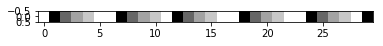

m (30, 1)


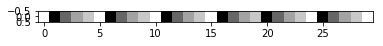

[ 0.4980536   0.61814153]


In [90]:
i = 0
plot.single(x_train[i,:30,0])
plot.single(x_train[i+1,:30,0])
print(y_train[i:i+2])

Make sure all frequencies fall inside the window

m (30, 1)


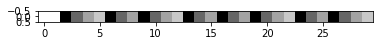

m (30, 1)


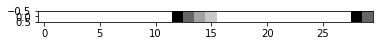

0.97672623719 0.00468381691798


In [91]:
i = y_train.argmax()
j = y_train.argmin()
plot.single(x_train[i,:30,0])
plot.single(x_train[j,:30,0])
print(y_train[i], y_train[j])

In [92]:
input_shape = x_train[0].shape
input_shape

(100, 1, 1)

In [118]:
timesteps, notes, channels = input_shape

encoder_input = Input(shape=(timesteps, notes, channels))
x = encoder_input

x = Reshape((timesteps, notes))(x)
x = LSTM(2)(x)
# x = Dense(10)(x)
x = Dense(1)(x)

encoder_output = x

model = Model(encoder_input, encoder_output, name='encoder-')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 100, 1, 1)         0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 100, 1)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [119]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta
model.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','binary_crossentropy'])

In [120]:
phase_mod = 0.1
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [121]:
batch_size = 32
epochs = 50

In [122]:
data_augmentation = False
# data_augmentation = True

callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

if not data_augmentation:
    print('Not using data augmentation.')
#     history = ae.fit(x_train, epochs=epochs, validation_data=(x_test, None))
    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        workers=4)

Not using data augmentation.
Train on 80 samples, validate on 20 samples
Epoch 1/50
80/80 [==============================] - 1s 9ms/step - loss: 0.9822 - acc: 0.0000e+00 - mean_absolute_error: 0.9045 - binary_crossentropy: 8.7056 - val_loss: 1.2701 - val_acc: 0.0000e+00 - val_mean_absolute_error: 1.0435 - val_binary_crossentropy: 10.5126
Epoch 2/50
80/80 [==============================] - 1s 8ms/step - loss: 0.9298 - acc: 0.0000e+00 - mean_absolute_error: 0.8752 - binary_crossentropy: 8.7056 - val_loss: 1.2269 - val_acc: 0.0000e+00 - val_mean_absolute_error: 1.0233 - val_binary_crossentropy: 10.5126
Epoch 3/50
80/80 [==============================] - 1s 8ms/step - loss: 0.8966 - acc: 0.0000e+00 - mean_absolute_error: 0.8564 - binary_crossentropy: 8.7056 - val_loss: 1.1929 - val_acc: 0.0000e+00 - val_mean_absolute_error: 1.0072 - val_binary_crossentropy: 10.4964
Epoch 4/50
80/80 [==============================] - 1s 8ms/step - loss: 0.8692 - acc: 0.0000e+00 - mean_absolute_error: 0.8413

80/80 [==============================] - 1s 7ms/step - loss: 0.4547 - acc: 0.0000e+00 - mean_absolute_error: 0.5743 - binary_crossentropy: 7.5404 - val_loss: 0.6522 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.7257 - val_binary_crossentropy: 9.8933
Epoch 32/50
80/80 [==============================] - 1s 7ms/step - loss: 0.4447 - acc: 0.0000e+00 - mean_absolute_error: 0.5667 - binary_crossentropy: 7.4332 - val_loss: 0.6394 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.7177 - val_binary_crossentropy: 9.8866
Epoch 33/50
80/80 [==============================] - 1s 7ms/step - loss: 0.4351 - acc: 0.0000e+00 - mean_absolute_error: 0.5594 - binary_crossentropy: 7.3647 - val_loss: 0.6270 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.7099 - val_binary_crossentropy: 9.8817
Epoch 34/50
80/80 [==============================] - 1s 7ms/step - loss: 0.4256 - acc: 0.0000e+00 - mean_absolute_error: 0.5522 - binary_crossentropy: 7.1991 - val_loss: 0.6144 - val_acc: 0.0000e+00 - val_mean_a

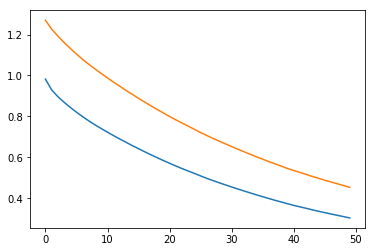

In [123]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

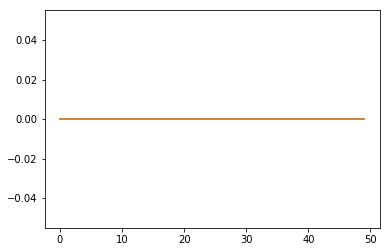

In [124]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

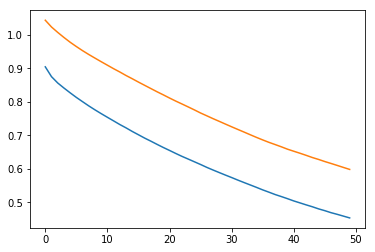

In [125]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [126]:
i = 2
model.predict(x_train)[i]

array([ 0.0486531], dtype=float32)

In [127]:
y_train[i]

0.85260315597359926